<a href="https://colab.research.google.com/github/rand-albej/simpson_vae/blob/main/simpson_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Can you generate faces?
##### We expect you to use images to generate new ones with a VAE. You have to write a dataloader to read images from the folder 'faces/', write a VAE class, a loss function, a training loop, and visualize your generated images.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import imageio as Image
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

### Nothing to change here (This cell downloads and unzips the data).

In [ ]:
!wget https://www.dropbox.com/s/4i466z18wsfvefl/faces.zip

!unzip faces.zip

!ls

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/faces/._4084.png  
  inflating: faces/3933.png          
  inflating: __MACOSX/faces/._3933.png  
  inflating: faces/2393.png          
  inflating: __MACOSX/faces/._2393.png  
  inflating: faces/1842.png          
  inflating: __MACOSX/faces/._1842.png  
  inflating: faces/4912.png          
  inflating: __MACOSX/faces/._4912.png  
  inflating: faces/326.png           
  inflating: __MACOSX/faces/._326.png  
  inflating: faces/440.png           
  inflating: __MACOSX/faces/._440.png  
  inflating: faces/9588.png          
  inflating: __MACOSX/faces/._9588.png  
  inflating: faces/8696.png          
  inflating: __MACOSX/faces/._8696.png  
  inflating: faces/6863.png          
  inflating: __MACOSX/faces/._6863.png  
  inflating: faces/454.png           
  inflating: __MACOSX/faces/._454.png  
  inflating: faces/8682.png          
  inflating: __MACOSX/faces/._8682.png  
  inflating: faces/6877.png          
  in

## Dataloader
####  Write a dataloader to read images from the folder 'faces/' (Note that the transform *trans* resizes the images to 32x32)

In [ ]:
trans = transforms.Compose([transforms.ToTensor(),transforms.Resize([32,32])])

# Replace the question marks '?' by the necessary code
batch_size =64

class MyDataset(Dataset):
  def __init__(self, image_path, transform = trans):
    self.image_path = image_path
    self.images = os.listdir(image_path)
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
     im = Image.imread(f'{self.image_path}{self.images[idx]}')
     im = self.transform(im)
     return im

In [ ]:
dataset = MyDataset("faces/")

train_loader = DataLoader(dataset, batch_size = batch_size)

#### Visualize the data
##### Get a batch from the dataloader and visualize its images

<ipython-input-65-e03d1d3206dc>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f'{self.image_path}{self.images[idx]}')


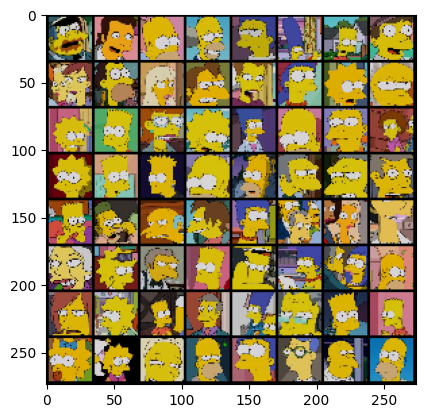

In [ ]:
# ADD CODE HERE
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images= next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'' for j in range(batch_size)))

### VAE class
#### Write a VAE class in the following cell

In [ ]:
# ADD CODE HERE
class VarAutoEncoder(nn.Module):
  def __init__(self, nz=64):
    super().__init__()
    self.nz = nz
    self.econv1 = nn.Conv2d(3, 16, 3, 2, 1)
    self.ebn1 = nn.BatchNorm2d(16)
    self.econv2 = nn.Conv2d(16, 32, 3, 2, 1)
    self.ebn2 = nn.BatchNorm2d(32)
    self.econv3 = nn.Conv2d(32,64, 3, 2, 1)
    self.ebn3 = nn.BatchNorm2d(64)
    self.elinear1 = nn.Linear(64*4*4, 128)
    self.ebn4 = nn.BatchNorm1d(128)

    self.dlinear1 = nn.Linear(nz,128)
    self.dbn1 = nn.BatchNorm1d(128)
    self.dlinear2 = nn.Linear(128,64*4*4)
    self.dbn2 = nn.BatchNorm2d(64)
    self.dconv1 = nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding =1)
    self.dbn3 = nn.BatchNorm2d(32)
    self.dconv2 = nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding =1)
    self.dbn4 = nn.BatchNorm2d(16)
    self.dconv3 = nn.ConvTranspose2d(16, 3, 3, 2, 1, output_padding =1)

    self.ulinear = nn.Linear(128,nz)
    self.slinear = nn.Linear(128,nz)


  def encoder (self,x):
    x = F.leaky_relu(self.econv1(x))
    x = self.ebn1(x)
    x = F.leaky_relu(self.econv2(x))
    x = self.ebn2(x)
    x = F.leaky_relu(self.econv3(x))
    x = self.ebn3(x)
    x = x.view(-1,64*4*4)
    x = F.leaky_relu(self.elinear1(x))
    x = self.ebn4(x)
    return x

  def decoder(self, x):
    x = F.leaky_relu(self.dlinear1(x))
    x = self.dbn1(x)
    x = F.leaky_relu(self.dlinear2(x))
    x = x.view(-1, 64,4,4)
    x = self.dbn2(x)
    x = F.leaky_relu(self.dconv1(x))
    x = self.dbn3(x)
    x = F.leaky_relu(self.dconv2(x))
    x = self.dbn4(x)
    x = torch.sigmoid(self.dconv3(x))
    return x

  def get_params(self,x):
    u = self.ulinear(x)
    logvar = self.slinear(x)
    return u, logvar

  def reparametarization(self, u, logvar):
    std = torch.exp(logvar/2)
    z = u + std*torch.randn_like(u)
    return z

  def forward(self,x):
    ex = self.encoder(x)
    u, logvar = self.get_params(ex)
    z = self.reparametarization(u, logvar)
    x = self.decoder(z)
    return ex,z, x, u, logvar

## Loss
#### Define Loss function in the following cell

In [ ]:
# ADD CODE HERE
ls = []
def var_loss(Xhat, X, u, logvar):
  KLD_WEIGHT = 0.0012
  term1 = F.mse_loss(Xhat, X)
  term2 = torch.mean(torch.sum(0.5*(1+logvar - torch.exp(logvar) - u**2), axis = 1), axis =0)
  return (1- KLD_WEIGHT)* term1 - KLD_WEIGHT*term2


### Training Loop
#### Define optimizer, write the training loop in the following cell, and plot the loss

<ipython-input-65-e03d1d3206dc>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f'{self.image_path}{self.images[idx]}')


0 15.47746891528368
1 12.613777473568916
2 11.281937718391418
3 10.584090366959572
4 10.108675550669432
5 9.724033273756504
6 9.419240653514862
7 9.202884748578072
8 9.027834996581078
9 8.902426850050688


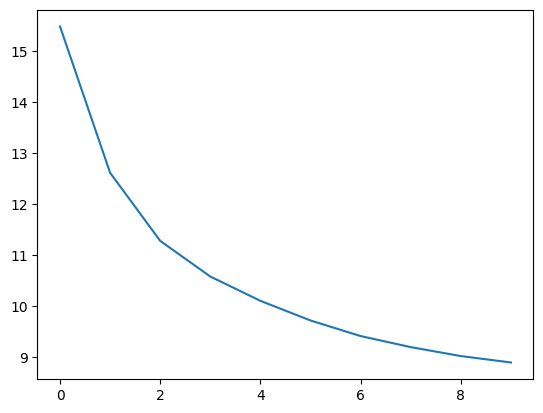

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Update the question marks '?' and add code where needed
nz = 32
net = VarAutoEncoder(32).to(device)
num_epochs = 10
lr = 0.0001
opt =optimizer = optim.Adam(net.parameters(), lr = lr)

for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    # ADD CODE HERE
    X = batch.to(device)
    ex, z,Xhat, u, logvar = net(X)
    loss = var_loss(Xhat, X, u, logvar)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print(i, total_loss)

  ls.append(total_loss)

plt.plot(ls)

## Generate and Plot Data
#### Generate a batch of 64 images and plot them in subplots of 8 rows and 8 columns.

In [ ]:
# ADD CODE HERE

net.eval()
z = torch.randn(64,32)

In [ ]:
net = net.to("cpu")
Xhat = net.decoder(z)

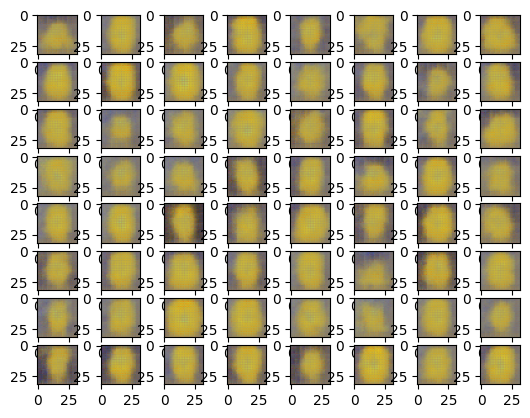

In [ ]:
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(np.transpose(Xhat[i,:,:,:].detach().cpu().numpy(), (1,2,0)))